In [54]:
import qiskit
import qiskit_machine_learning as qml
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
from qiskit.circuit import Parameter, ParameterExpression, ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels.parameterized_quantum_kernel import ParamQuantumKernel
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit import QuantumCircuit, Aer
from qiskit.aqua import QuantumInstance

import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial,reduce
import numpy as np
import copy
from copy import deepcopy as dc

# Generate a trivial dataset

In [29]:
x_vec = [[ 0,  2],
         [.1, .4],
         [.5, .3],
         [.8, .2]]
y = [1, 1, -1, -1]

### Define the objective function used to train the PQK

In [30]:
def obj_align(params, PQK=None, x_vec=None, y=None):
    assert PQK is not None
    assert x_vec is not None
    assert y is not None
    
    # check that params are the right dimension
    PQK.bind_free_params(params)
    K = PQK.evaluate(x_vec)
    y = np.array(y)
    
    return -1 * y.T @ K @ y



### Instantiate and train the PQK

In [74]:
# Define my feature map, partition my parameters
n_qubits = 4
fm = ZZFeatureMap(n_qubits, reps=2)
input_params = fm.parameters[::2]
free_params = fm.parameters[1::2]

# instantiate a simulator backend
qi = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))

# Define my parameterized Kernel
pqk = ParamQuantumKernel(fm, free_params, input_params, quantum_instance=qi)

# Bind neccesary inputs to objective_function, such that it
# has `f(free_param_values) = real-scalar` usage.
alignment = partial(obj_align, PQK=pqk, x_vec=x_vec, y=y)


cb_results = [[],[],[],[],[]]
def callback(x0,x1=None,x2=None,x3=None,x4=None):
    cb_results[0].append(x0)
    cb_results[1].append(x1)
    cb_results[2].append(x2)
    cb_results[3].append(x3)
    cb_results[4].append(x4)
    
# instantiate an optimizer
spsa = SPSA(maxiter = 250, callback=callback)
#spsa = COBYLA(maxiter = 250, callback=callback)


# do kernel alignment
results = pqk.train_kernel(objective_function=alignment, 
                           optimizer=spsa)
results.__dict__

{'_optimizer_evals': 750,
 '_optimizer_time': 175.71048498153687,
 '_optimal_value': -4.378528231808905,
 '_optimal_point': array([-0.27177623, -0.58191131]),
 '_optimal_parameters': {ParameterVectorElement(x[0]): -0.2717762332491779,
  ParameterVectorElement(x[2]): -0.5819113108746705}}

Text(0.5, 1.0, 'Variational Kernel Alignment Training')

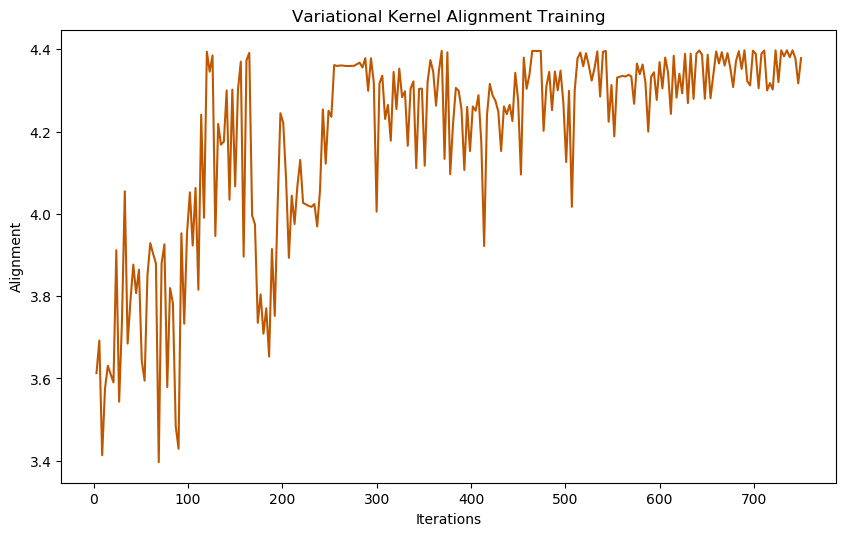

In [73]:
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 100
plt.plot(cb_results[0], -1*np.array(cb_results[2]), color='#bf5700')
plt.xlabel('Iterations')
plt.ylabel('Alignment')
plt.title("Variational Kernel Alignment Training")


# Below is the actual kernel matrix we learned
### Note that the data is sorted by class, so theoretically optimal kernel would be block diagonal: 

$K_{ideal}$ = ```[[1, 1, 0, 0]
        [1, 1, 0, 0]
        [0, 0, 1, 1]
        [0, 0, 1, 1]]```

In [76]:
pqk.evaluate(x_vec)

array([[1.        , 0.15313172, 0.0118869 , 0.01924197],
       [0.15313172, 1.        , 0.0199881 , 0.02610138],
       [0.0118869 , 0.0199881 , 1.        , 0.11335075],
       [0.01924197, 0.02610138, 0.11335075, 1.        ]])

# There's still bugs downstream when we try to use the final kernel

In [57]:
# the free_params from our PQK have been bound to the feature map circuit already.
qk = QuantumKernel(feature_map=pqk._feature_map,
                   quantum_instance=qi)

In [58]:
from qiskit_machine_learning.algorithms import QSVC
qsvc = QSVC(quantum_kernel = qk )
qsvc.fit(x_vec, y)

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


RuntimeError: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'qiskit_machine_learning.algorithms.classifiers.qsvc.QSVC'> with constructor (self, *args, quantum_kernel: Union[qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel, NoneType] = None, **kwargs) doesn't  follow this convention.